made by 조정효

In [1]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# technical analysis
import ta

## data: 5 minutes data

In [2]:
df_ = pd.read_csv('C:ethusd5min.csv')
df = df_.set_index('timestamp')
df.index = pd.to_datetime(df.index)
df

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2020-04-10 00:00:00,169.56,169.72,169.41,169.43,2906.41820,1586477099999,4.930542e+05,707,2260.79119,3.835677e+05,0
2020-04-10 00:05:00,169.44,169.59,168.92,169.22,3376.45186,1586477399999,5.711061e+05,1004,1951.63764,3.301054e+05,0
2020-04-10 00:10:00,169.23,169.42,168.70,168.78,3007.20677,1586477699999,5.081008e+05,752,929.71120,1.571687e+05,0
2020-04-10 00:15:00,168.84,169.12,168.80,169.00,1465.81110,1586477999999,2.476386e+05,472,637.17163,1.076405e+05,0
2020-04-10 00:20:00,168.99,169.40,168.96,169.36,1067.16710,1586478299999,1.806507e+05,418,343.42918,5.811992e+04,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-09 23:40:00,2066.80,2069.36,2065.89,2067.74,696.35201,1618011899999,1.439804e+06,1078,350.52749,7.246912e+05,0
2021-04-09 23:45:00,2067.75,2070.85,2067.62,2070.42,1039.88778,1618012199999,2.152313e+06,1344,554.96546,1.148618e+06,0
2021-04-09 23:50:00,2070.42,2070.95,2069.05,2069.52,773.88383,1618012499999,1.601904e+06,1142,428.07969,8.860856e+05,0


In [3]:
close = pd.to_numeric(df.close)

- SMA crossover
- RSI
- BB Band


### SMA crossover

In [75]:
fsma = ta.trend.sma_indicator(close,10*5)
ssma = ta.trend.sma_indicator(close,40*5)

In [76]:
diff = fsma - ssma
a = np.sign(diff).diff()*(.5)
crossover = a.loc[a!=0].dropna()

In [77]:
longs_sma = crossover.loc[crossover==1]
shorts_sma = crossover.loc[crossover==-1]

### BB

In [78]:
window = 40*5

bbh = ta.volatility.bollinger_hband(close,window)
bbl = ta.volatility.bollinger_lband(close,window)

In [79]:
long_ind = close.loc[(np.sign(close-bbl).diff() == 2)].index
short_ind = close.loc[(np.sign(close-bbh).diff() == -2)].index

In [80]:
longs_bb  = pd.Series(1, index=long_ind)
shorts_bb = pd.Series(-1, index=short_ind)

### RSI

In [81]:
window = 12*5

rsi = ta.momentum.rsi(close,window)
rsi_down = rsi.loc[rsi<50]
rsi_up = rsi.loc[rsi>=50]

In [82]:
up_thresh = 75
down_thresh = 33

longs_rsi = pd.Series(1, rsi_down.loc[np.sign(rsi_down-down_thresh).diff() == 2].index)
shorts_rsi = pd.Series(-1, rsi_up.loc[np.sign(rsi_up-up_thresh).diff() == -2].index)

## Choose regime

In [60]:
import rolling_hurst as rh

In [62]:
hursts = rh.rolling_hurst(close,12*24*7) #weekly

C:\Users\JHCho\anaconda3\envs\py37\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [65]:
hursts.to_csv('hurst_exp_week.csv')

In [71]:
hurstexp = hursts.hurst

In [73]:
mom = hurstexp.loc[hurstexp>0.5]
mr = hurstexp.loc[hurstexp<=0.5]

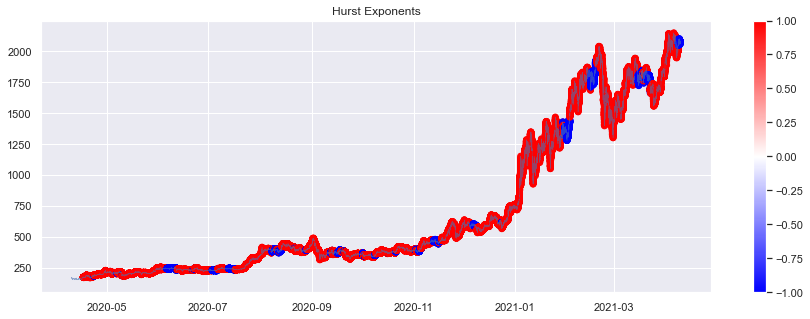

In [74]:
sc= np.sign(hurstexp-0.5)
title = 'Hurst Exponents'
cmap='bwr'
figsize=(15,5)

plt.figure(figsize=figsize)
plt.plot(close, linewidth=0.5,alpha=0.6)
plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1)
plt.colorbar()
plt.title(title)
plt.show()

## Signal

- choose what  i like

- for mom SMA
- for mv BB

In [103]:
signals_mom = pd.concat([longs_sma, shorts_sma]).sort_index()
signals_mr = pd.concat([longs_bb, shorts_bb]).sort_index()

In [104]:
df_signal_mom = pd.DataFrame({'hurst':mom,'signal':signals_mom}).dropna()
df_signal_mr = pd.DataFrame({'hurst':mr,'signal':signals_mr}).dropna()

In [107]:
sgn1 = df_signal_mom.signal

In [118]:
sgn2 = df_signal_mr.signal

In [158]:
sgn2 = sgn2.diff().dropna()*.5 # drop when same signal follows
sgn2 = sgn2.loc[sgn2!=0]

In [159]:
signal = sgn1.append(sgn2).sort_index()

In [160]:
signal = signal.diff().dropna()*.5 # drop when same signal follows
signal = signal.loc[signal!=0]

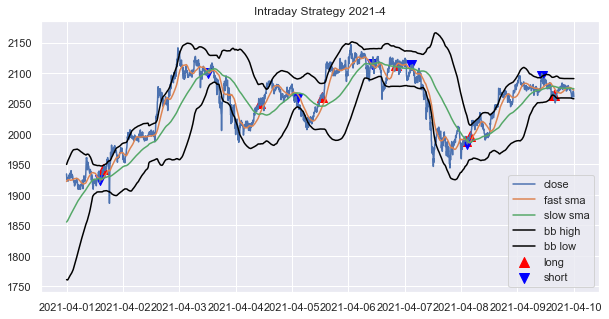

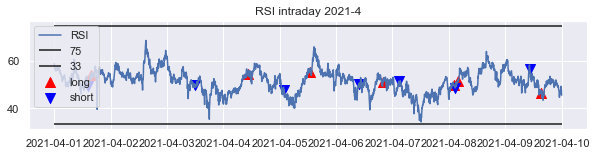

In [161]:
# Intraday
sc = signal
title =  'Intraday Strategy'
title2 = 'RSI intraday'

long = close.loc[sc.loc[sc==1].index]
short = close.loc[sc.loc[sc==-1].index]

long2 = rsi.loc[sc.loc[sc==1].index]
short2 = rsi.loc[sc.loc[sc==-1].index]

day = ' 2021-4'
s = 100

plt.figure(figsize=(10,5))
plt.plot(close.loc[day])
plt.plot(fsma.loc[day])
plt.plot(ssma.loc[day])
plt.plot(bbh.loc[day], c='black')
plt.plot(bbl.loc[day], c='black')
plt.scatter(long.loc[day].index, long.loc[day],s=s, c='red',marker='^', alpha=1)
plt.scatter(short.loc[day].index, short.loc[day],s=s, c='blue',marker='v', alpha=1)
plt.legend(['close','fast sma','slow sma','bb high','bb low', 'long','short'])
plt.title(title + day)
plt.show()

plt.figure(figsize=(10,2))
plt.plot(rsi.loc[day])
plt.hlines(up_thresh, rsi.loc[day].index[0],rsi.loc[day].index[-1])
plt.hlines(down_thresh, rsi.loc[day].index[0],rsi.loc[day].index[-1])
plt.scatter(long2.loc[day].index, long2.loc[day],s=s, c='red',marker='^', alpha=1)
plt.scatter(short2.loc[day].index, short2.loc[day],s=s, c='blue',marker='v', alpha=1)
plt.legend(['RSI',up_thresh, down_thresh,'long','short'])
plt.title(title2 + day)
plt.show()

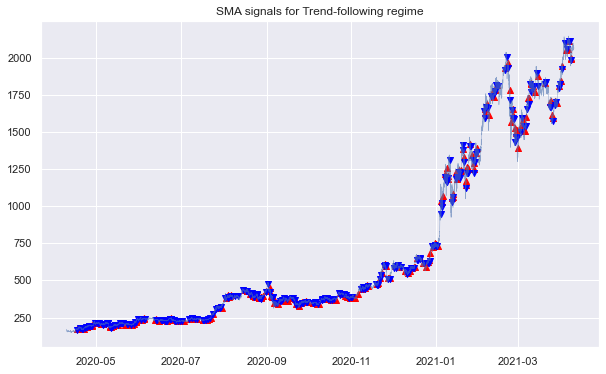

In [165]:
sc = sgn1
title =  'SMA signals for Trend-following regime'

long = close.loc[sc.loc[sc==1].index]
short = close.loc[sc.loc[sc==-1].index]

plt.figure(figsize=(10,6))
plt.plot(close, linewidth=0.5,alpha=0.6)
plt.scatter(long.index, long, c='red',marker='^', alpha=1)
plt.scatter(short.index, short, c='blue',marker='v', alpha=1)

plt.title(title)
plt.show()

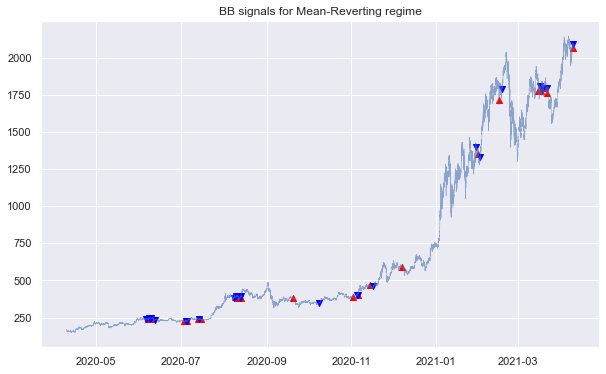

In [166]:
sc = sgn2
title =  'BB signals for Mean-Reverting regime'

long = close.loc[sc.loc[sc==1].index]
short = close.loc[sc.loc[sc==-1].index]

plt.figure(figsize=(10,6))
plt.plot(close, linewidth=0.5,alpha=0.6)
plt.scatter(long.index, long, c='red',marker='^', alpha=1)
plt.scatter(short.index, short, c='blue',marker='v', alpha=1)

plt.title(title)
plt.show()

In [167]:
mult = (signal+1)/2
rets = (close.loc[signal.index].pct_change().shift(-1))*mult
rets = rets.loc[rets!=0].dropna()

In [168]:
rets

2020-04-17 20:05:00    0.064267
2020-04-19 22:25:00   -0.016803
2020-04-21 08:50:00   -0.009140
2020-04-21 19:45:00   -0.004874
2020-04-22 05:10:00    0.047822
                         ...   
2021-04-04 10:20:00    0.003072
2021-04-05 12:55:00    0.026742
2021-04-06 20:10:00    0.000090
2021-04-08 02:00:00   -0.002575
2021-04-08 03:55:00    0.048655
Length: 289, dtype: float64

In [169]:
rets.describe()

count    289.000000
mean       0.006880
std        0.039596
min       -0.077079
25%       -0.013281
50%       -0.004117
75%        0.013502
max        0.295931
dtype: float64

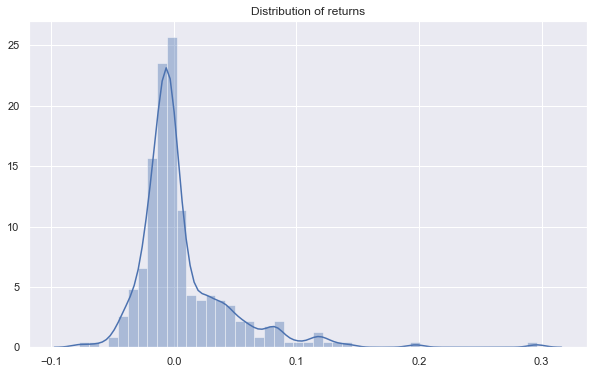

In [170]:
plt.figure(figsize=(10,6))
sns.distplot(rets)
plt.title('Distribution of returns')
plt.show()

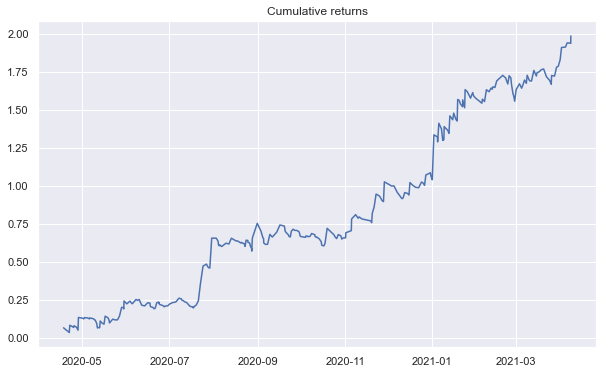

In [171]:
plt.figure(figsize=(10,6))
plt.plot(rets.cumsum())
plt.title('Cumulative returns')
plt.show()

In [172]:
SR = rets.mean()/rets.std()
ASR = SR * np.sqrt(len(rets))
print('Ann Sharpe Ratio: ',ASR)

Ann Sharpe Ratio:  2.9537133822356654


## Investment simulation

In [173]:
init_money = 5000

signals = signals.rename('signals')
rets = rets.rename('returns')
results_0 = close.to_frame().join(signals).dropna().join(rets)

buys = np.floor(init_money/results_0.close).loc[results_0.signals==1].rename('buys')
results_1 = results_0.join(buys)

sells = results_1.buys.shift(1).rename('sells')
results_2 = results_1.join(sells)

buy_amount = (results_2.buys*results_2.close).rename('buy_amount')
sell_amount = (results_2.sells*results_2.close).rename('sell_amount')
results_3 = results_2.join([buy_amount,sell_amount])

temp_ = -1*results_3.buy_amount.fillna(0)+results_3.sell_amount.fillna(0)
temp_[0] = init_money
account = temp_.cumsum()
results_4 = results_3.join(account.rename('cash_inventory'))

In [174]:
results_4

,close,signals,returns,buys,sells,buy_amount,sell_amount,cash_inventory
timestamp,,,,,,,,
2020-04-11 14:40:00,157.53,-1.0,NaN,NaN,NaN,NaN,NaN,5000.00
2020-04-12 13:20:00,159.66,1.0,NaN,31.0,NaN,4949.46,NaN,50.54
2020-04-13 03:55:00,152.36,-1.0,NaN,NaN,31.0,NaN,4723.16,4773.70
2020-04-14 01:45:00,157.07,1.0,NaN,31.0,NaN,4869.17,NaN,-95.47
2020-04-15 13:55:00,156.67,-1.0,NaN,NaN,31.0,NaN,4856.77,4761.30
...,...,...,...,...,...,...,...,...
2021-04-06 19:10:00,2118.33,-1.0,NaN,NaN,2.0,NaN,4236.66,15692.39
2021-04-07 00:10:00,2124.29,1.0,NaN,2.0,NaN,4248.58,NaN,11443.81
2021-04-07 02:20:00,2105.12,-1.0,NaN,NaN,2.0,NaN,4210.24,15654.05


In [175]:
buy_amount

timestamp
2020-04-11 14:40:00        NaN
2020-04-12 13:20:00    4949.46
2020-04-13 03:55:00        NaN
2020-04-14 01:45:00    4869.17
2020-04-15 13:55:00        NaN
                        ...   
2021-04-06 19:10:00        NaN
2021-04-07 00:10:00    4248.58
2021-04-07 02:20:00        NaN
2021-04-08 12:55:00    4059.08
2021-04-09 23:10:00        NaN
Name: buy_amount, Length: 355, dtype: float64

### Benchmark
- return every 1 day (daily returns)

In [176]:
rets_b = close.iloc[::12*24].pct_change().dropna()

In [177]:
rets_b

timestamp
2020-04-11 00:00:00   -0.064865
2020-04-12 00:00:00    0.003408
2020-04-13 00:00:00   -0.012391
2020-04-14 00:00:00    0.002739
2020-04-15 00:00:00   -0.003430
                         ...   
2021-04-05 14:35:00    0.015163
2021-04-06 14:35:00   -0.018137
2021-04-07 14:35:00   -0.033357
2021-04-08 14:35:00    0.019816
2021-04-09 14:35:00    0.009733
Name: close, Length: 364, dtype: float64

In [178]:
rets_b.describe()

count    364.000000
mean       0.007912
std        0.045216
min       -0.158700
25%       -0.013237
50%        0.005597
75%        0.028022
max        0.180893
Name: close, dtype: float64

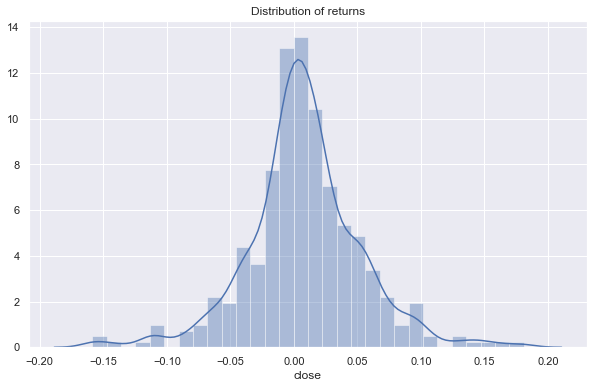

In [179]:
plt.figure(figsize=(10,6))
sns.distplot(rets_b)
plt.title('Distribution of returns')
plt.show()

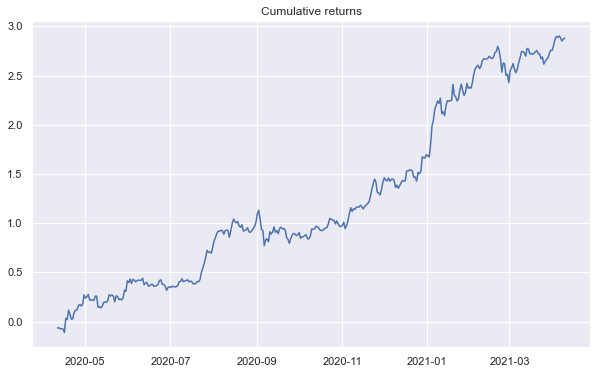

In [180]:
plt.figure(figsize=(10,6))
plt.plot(rets_b.cumsum())
plt.title('Cumulative returns')
plt.show()

In [181]:
SR = rets_b.mean()/rets_b.std()
ASR = SR * np.sqrt(len(rets_b))
print('Ann Sharpe Ratio: ',ASR)

Ann Sharpe Ratio:  3.338377251222563
